

<div align="center">
<p align="center">


# 🚀 Synthetic Data Generator

</p>
</div>

The Synthetic Data Generator (SDG) is a specialized framework designed to generate high-quality structured tabular data. It incorporates a wide range of single-table, multi-table data synthesis algorithms and LLM-based synthetic data generation models.

Synthetic data, generated by machines using real data, metadata, and algorithms, does not contain any sensitive information, yet it retains the essential characteristics of the original data. There is no direct correlation between synthetic data and real data, making it exempt from privacy regulations such as GDPR and ADPPA. This eliminates the risk of privacy breaches in practical applications.

In [1]:
# install dependencies
!pip install sdgx
!pip install table_evaluator
!pip install joblib==1.3.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.1/205.1 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 29.3 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.0.3 which is incompatible.


We demonstrate with a single table data synthetic example.

In [2]:
from sdgx.data_connectors.csv_connector import CsvConnector
from sdgx.models.ml.single_table.ctgan import CTGANSynthesizerModel
from sdgx.synthesizer import Synthesizer
from sdgx.data_loader import DataLoader
from sdgx.data_models.metadata import Metadata

# 1. Load data and understand the data

The demo data set for this demonstration is a risk control data set used to predict whether an individual will default on a loan. This dataset contains the following features:

| Column name | Meaning |
|-----------------------|-----------------------|
| loan_id | loan ID |
| user_id | user ID |
| total_loan | Total loan amount |
| year_of_loan | Loan period |
...

This code shows the process of loading real data:

In [3]:
# Data preprocessing:
# - remove empty data: useless
# - Remove nan: will cause an error
# In the future, this part of the function will be integrated into `sdgx.processor`

import pandas as pd
import requests


def download_file(url, path):
    response = requests.get(url)
    if response.status_code == 200:
        with open(path, 'wb') as file:
            file.write(response.content)
        print(f"File downloaded successfully to {path}")
    else:
        print(f"Failed to download file from {url}")

def remove_empty_rows(input_file, output_file):
    with open(input_file, 'r') as file:
        lines = file.readlines()

    valid_lines = [line for line in lines if ',,' not in line]

    with open(output_file, 'w') as file:
        file.writelines(valid_lines)

def clear_na(csv_file, output_file):

    df = pd.read_csv(csv_file)
    df = df.fillna(0)

    df.to_csv(output_file, index=False)

# download dataset from github
# This datajset can be downloaded through sdgx.utils in the future

dataset_url = "https://raw.githubusercontent.com/aialgorithm/Blog/master/projects/一文梳理风控建模全流程/train_internet.csv"
download_file(dataset_url, "train_internet.csv")
remove_empty_rows('train_internet.csv', 'train_internet.csv')
clear_na('train_internet.csv', 'train_internet.csv')

File downloaded successfully to train_internet.csv


In [4]:
from pathlib import Path
file_path = './train_internet.csv'
path_obj = Path(file_path)

# Create a data connector and data loader for csv data
data_connector = CsvConnector(path=path_obj)
data_loader = DataLoader(data_connector)

# 2. Create synthetic data generation workflow

Below we will use SDG to create a data synthetic workflow. This workflow includes steps such as automated metadata identification, which will help generate high-quality synthetic data:

Firstly, we need to create a metadata object. SDG provides automated metadata identification functions that can extract key information from existing data sources, such as data type, data range, data distribution, etc.

In [5]:
loan_metadata = Metadata.from_dataloader(data_loader)
# Automatically infer discrete columns
loan_metadata.discrete_columns

2024-02-27 03:52:55.898 | INFO     | sdgx.data_models.metadata:from_dataloader:243 - Inspecting metadata...
2024-02-27 03:52:56.186 | INFO     | sdgx.data_models.metadata:update_primary_key:445 - Primary Key updated: {'user_id', 'loan_id'}.


{'class',
 'earlies_credit_mon',
 'employer_type',
 'industry',
 'issue_date',
 'sub_class',
 'work_type',
 'work_year'}

After the model definition is completed, we can use SDG to generate synthetic data.

In [6]:
# Initialize synthesizer, use CTGAN model
synthesizer = Synthesizer(
    metadata= loan_metadata,
    model=CTGANSynthesizerModel(epochs=2),
    data_connector=data_connector,
)

# 3. Train a model
CTGAN (Conditional Tabular GAN) is a generative neural network model used to generate synthetic tabular data.

Its principle is to achieve data generation by training a generator network and a discriminator network.

The main parameters of CTGAN include:

* embedding_dim: embedding dimension, used to convert discrete features into continuous vector representation.
* generator_dim: the hidden layer dimension of the generator network.
* discriminator_dim: the hidden layer dimension of the discriminator network.
* generator_lr: The learning rate of the generator network.
* discriminator_lr: The learning rate of the discriminator network.
*batch_size: The number of samples in each training batch.
* epochs: The number of iterations of training.

The significance of these parameters is to adjust the performance of the model and the stability of the training process. A larger embedding dimension can improve the representation ability of discrete features, while a larger hidden layer dimension can increase the complexity of the network. The learning rate and batch size can affect the convergence speed and stability of the model, while the number of iterations determines the training time of the model.

In [7]:
# Fit the model
synthesizer.fit()

2024-02-27 03:52:56.268 | INFO     | sdgx.synthesizer:fit:288 - Fitting data processors...
2024-02-27 03:52:56.275 | INFO     | sdgx.synthesizer:fit:298 - Initializing processed data loader...
2024-02-27 03:52:56.440 | INFO     | sdgx.synthesizer:fit:305 - Initialized processed data loader in 0.15967345237731934s
2024-02-27 03:52:56.443 | INFO     | sdgx.synthesizer:fit:307 - Starting model fit...
2024-02-27 03:52:56.520 | INFO     | sdgx.models.ml.single_table.ctgan:_pre_fit:221 - Fitting model's transformer...
2024-02-27 03:53:29.446 | INFO     | sdgx.models.ml.single_table.ctgan:_pre_fit:223 - Transforming data...
2024-02-27 03:53:44.128 | INFO     | sdgx.models.ml.single_table.ctgan:_fit:271 - Starting training, epochs: 2


# 4. Generate synthetic data

In [8]:
# Sample
real_data = data_loader.load_all()
sampled_data = synthesizer.sample(100)

print(sampled_data)

2024-02-27 03:54:01.983 | INFO     | sdgx.synthesizer:sample:332 - Sampling...


    loan_id  user_id    total_loan  year_of_loan   interest  monthly_payment  \
0    189184   689138  18884.217063             3  14.988235       363.855977   
1    404147     1974  10730.206870             3  11.778960       282.572523   
2    774177    -3921  15858.847042             3  15.428744       435.561658   
3    163792   680182  31969.772011             5  14.639817       124.992561   
4    615798    -2290  26161.987437             3  18.166283       987.010936   
..      ...      ...           ...           ...        ...              ...   
95   709480    -1340   3742.649742             3  11.705346       375.196357   
96    79849   729980  15597.461468             3   8.324608       522.754107   
97   421376     -614  22703.289751             3  14.454318      1009.007669   
98   299356    -1623  24754.922847             3  16.309554       395.894063   
99   813196     1160  35947.011581             3  16.561143       229.843290   

   class sub_class work_type employer_t

In [9]:
sampled_data

# real_data

,loan_id,user_id,total_loan,year_of_loan,interest,monthly_payment,class,sub_class,work_type,employer_type,...,earlies_credit_mon,title,policy_code,f0,f1,f2,f3,f4,f5,is_default
0,189184,689138,18884.217063,3,14.988235,363.855977,C,G2,公务员,幼教与中小学校,...,Sep-2010,-216.418967,0.998243,3.208403,0.001120,5.289274,13.576236,5.237824,-0.008198,-0.004068
1,404147,1974,10730.206870,3,11.778960,282.572523,B,A1,工人,政府机构,...,Oct-2009,139.487037,1.000889,2.972735,0.001681,6.091987,8.187505,5.390142,-0.018078,-0.000952
2,774177,-3921,15858.847042,3,15.428744,435.561658,B,F4,公务员,幼教与中小学校,...,Dec-1995,-7.937948,0.997924,21.925804,0.001771,11.448444,12.753036,7.269979,9.319956,0.011630
3,163792,680182,31969.772011,5,14.639817,124.992561,F,A5,工人,高等教育机构,...,Apr-1979,185.515308,0.998911,12.258426,0.001881,16.772411,22.311078,7.986091,11.958815,-0.005521
4,615798,-2290,26161.987437,3,18.166283,987.010936,D,E2,其他,政府机构,...,Oct-1977,169.501134,0.999372,4.194023,0.001658,14.264091,12.730784,3.746888,3.266448,-0.005583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,709480,-1340,3742.649742,3,11.705346,375.196357,F,C1,工程师,世界五百强,...,Dec-1981,5.275558,0.998703,6.217073,0.001850,6.759156,7.980285,0.817183,2.928114,-0.003220
96,79849,729980,15597.461468,3,8.324608,522.754107,D,C1,职员,政府机构,...,Apr-2003,-76.312497,0.997852,3.931700,0.001006,2.882815,23.706809,6.873324,0.024090,0.011676
97,421376,-614,22703.289751,3,14.454318,1009.007669,E,B5,工程师,普通企业,...,Jul-2008,57.300885,0.998663,6.207131,-0.000485,6.177840,2.954451,11.955252,0.004692,1.044014
98,299356,-1623,24754.922847,3,16.309554,395.894063,D,A3,公务员,普通企业,...,May-2001,-136.131053,0.999427,13.939672,0.000823,26.989405,11.256377,6.140183,-0.003827,0.008590


# 5. Data quality assessment on synthetic data

In the field of simulated data, the comparison of the mean and variance of each feature between real data and simulated data is very important:

1. The mean and variance of real data reflect the data distribution in the real world. By comparing the mean and variance of real and simulated data on each feature, the accuracy and credibility of the simulated data can be evaluated.

2. The mean and variance are important statistics that describe the center and dispersion of the data set. The mean reflects the central tendency of the data set, and the variance reflects the dispersion of the data set. By comparing the mean and variance of real and simulated data on each feature, you can evaluate whether the simulated data accurately simulates the central tendency and dispersion of the real data.

--2024-02-27 03:57:40--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 74.125.134.113, 74.125.134.100, 74.125.134.102, ...
Connecting to drive.google.com (drive.google.com)|74.125.134.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2024-02-27 03:57:40--  https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 172.217.193.132, 2607:f8b0:400c:c03::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|172.217.193.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20659344 (20M) [application/octet-stream]
Saving to: ‘TaipeiSansTCBeta-Regular.ttf’

TaipeiSansTCBeta-Re 100%[===================>]  19.70M  --.-KB/s    in 0.1s    

2024-02-27 03:5

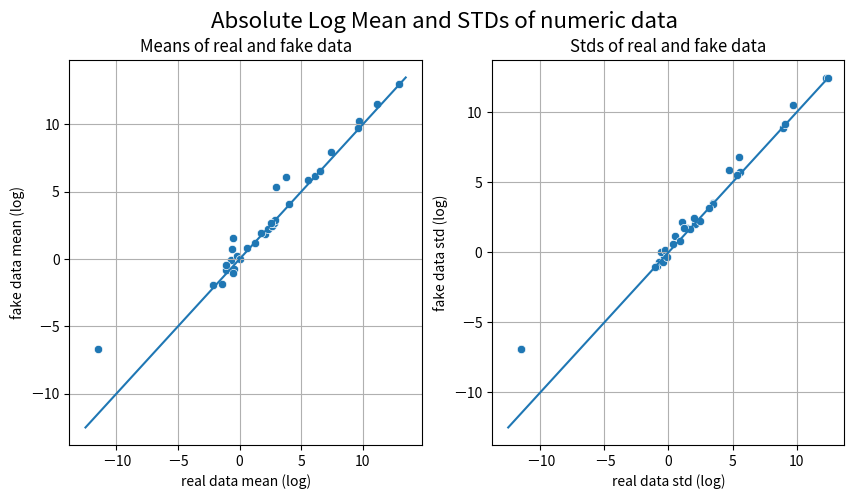

In [14]:
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import fontManager

fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
matplotlib.rc('font', family='Taipei Sans TC Beta')

# use table_evaluator for evaluation
from table_evaluator import TableEvaluator

table_evaluator = TableEvaluator(
    real_data[list(set(real_data.columns) - set(loan_metadata.discrete_columns))],
    sampled_data[list(set(real_data.columns) - set(loan_metadata.discrete_columns))])
table_evaluator.plot_mean_std()

There are 42 columns in the target list. We select some important features for **statistical distribution assessment**.

Through the analysis of these features, we can have a more comprehensive understanding of the borrower's professional status, work experience, industry background, and repayment so as to more accurately assess its loan risk and credit reliability, as follows:

1. work_type (work type): Indicates the borrower’s work type, such as clerk, worker, other, etc. This characteristic is important in understanding a borrower's professional identity and stability, as different job types may have an impact on a borrower's ability to repay.

2. work_year (working years): Indicates the borrower’s working years in the current workplace. This feature can reflect the borrower’s work experience and stability. Borrowers who have worked for the same unit for a long time may have greater repayment ability and credit reliability.

3. Industry: Indicates the industry in which the borrower is located, such as mining, information transmission, finance, etc. Understanding the borrower's industry can help us evaluate the borrower's career stability and industry prospects, and thus determine his or her repayment ability.

4. monthly_payment (monthly payment amount): Indicates the loan amount that the borrower needs to repay every month. This feature is an important indicator for evaluating the borrower's repayment ability. A higher monthly payment may mean that the borrower has heavier debts and requires higher repayment ability.

5. post_code (postal code): Indicates the postal code of the borrower's location. Postal codes can provide geographic location information about the borrower's location, which helps us understand the economic conditions and risk profile of the borrower's location.

6. recircle_b (revolving line usage rate): Indicates the proportion of the revolving line used by the borrower to the total revolving line. Revolving limit refers to a credit card or other credit card that can be used repeatedly. The borrower's utilization rate can reflect his or her credit card usage and repayment habits, which is of great significance for assessing the borrower's credit status and repayment ability.

/usr/local/lib/python3.10/dist-packages/table_evaluator/table_evaluator.py:182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(axes[i].get_xticklabels(), rotation='vertical')
/usr/local/lib/python3.10/dist-packages/table_evaluator/table_evaluator.py:182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(axes[i].get_xticklabels(), rotation='vertical')
/usr/local/lib/python3.10/dist-packages/table_evaluator/table_evaluator.py:182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(axes[i].get_xticklabels(), rotation='vertical')


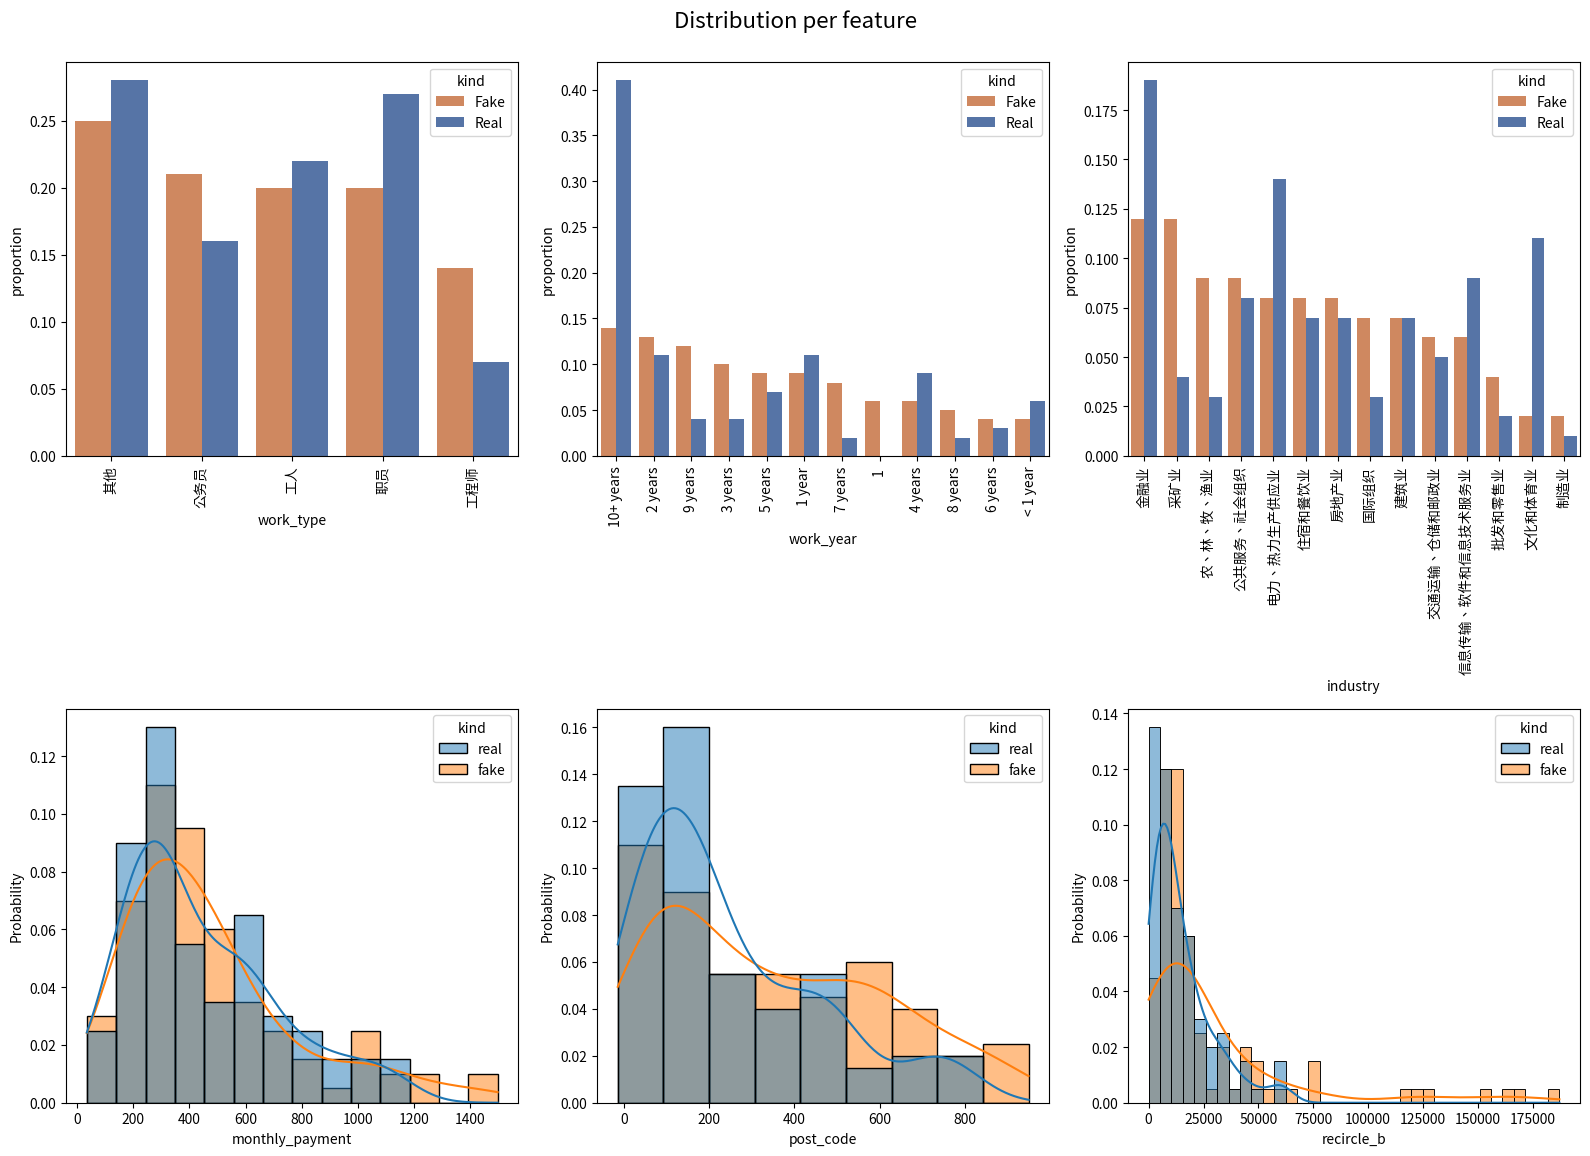

In [15]:
target_cols = ['work_type','work_year','industry','monthly_payment',  'post_code',"recircle_b" ]

table_evaluator = TableEvaluator(real_data.loc[:, target_cols], sampled_data.loc[:, target_cols], cat_cols= ["work_year", "work_type", 'industry'])
table_evaluator.plot_distributions(nr_cols=3)